
# Credit Card Fraud Prediction with XGBoost
_**Using Gradient Boosted Trees to Predict Fraudulent Transactions**_

### All the code is on this github repo: https://github.com/wmlba/innovate2019

---

---

## Contents

1. [Background](#Background)
1. [Setup](#Setup)
1. [Data](#Data)
1. [Train](#Train)
1. [Host](#Host)
  1. [Evaluate](#Evaluate)

---

## Background



Identifying Credit Card Fraudulent transaction is crucial to the banking business to protect their customers from fraud. Identifying fraud transactions is not an easy task and it can consume a lot of auditors time to identify those transactions and it can delay the purchasing of whatever items the card holder wants to purchase.

In this notebook, I will demonstrate how to build an binary classification model to predict whether a specific credit card transaction is genuine of fraud. I will use Sagemaker's implementation of XGBoost algorithm.



## Amazon SageMaker
Amazon SageMaker Amazon SageMaker is a fully managed machine learning service that automates the end-to-end ML process. With Amazon SageMaker, data scientists and developers can quickly and easily build and train machine learning models and directly deploy them into a production-ready hosted environment. It provides an integrated Jupyter authoring notebook instance for easy access to your data sources for exploration and analysis, so you don't have to manage servers. It also provides common machine learning algorithms that are optimized to run efficiently against extremely large data in a distributed environment. With native support for bring-your-own-algorithms and frameworks, Amazon SageMaker offers flexible distributed training options that adjust to your specific workflows.

---
## Machine Learning Process

<img src="./MLProcess.png">





## Decision Trees and XGBoost

<img src="./decision_trees2.png" width="700" height="700">
<img src="./decision_trees.png" width="700" height="700">


**Source:** https://xgboost.readthedocs.io/en/latest/tutorials/model.html


### Why XGBoost? 

## Setup

_This notebook was created and tested on an ml.m4.xlarge notebook instance._

Let's start by specifying:

- The S3 bucket and prefix that you want to use for training and model data.  This should be within the same region as the Notebook Instance, training, and hosting.
- The IAM role arn used to give training and hosting access to your data. See the documentation for how to create these.  Note, if more than one role is required for notebook instances, training, and/or hosting, please replace the boto regexp with a the appropriate full IAM role arn string(s).

In [62]:
!pip3 install -U imbalanced-learn xgboost

Requirement already up-to-date: imbalanced-learn in /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages (0.6.2)
    100% |████████████████████████████████| 109.8MB 299kB/s eta 0:00:01   13% |████▎                           | 14.5MB 25.2MB/s eta 0:00:04    63% |████████████████████▌           | 70.1MB 22.1MB/s eta 0:00:02�█████████████████▏| 106.9MB 66.8MB/s eta 0:00:01
Requirement not upgraded as not directly required: scipy>=0.17 in /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages (from imbalanced-learn) (1.1.0)
Requirement not upgraded as not directly required: joblib>=0.11 in /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages (from imbalanced-learn) (0.14.1)
Requirement not upgraded as not directly required: numpy>=1.11 in /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages (from imbalanced-learn) (1.14.3)
Requirement not upgraded as not directly required: scikit-learn>=0.22 in /home/ec2-user/anaconda3/envs/python3/lib/pyth

In [2]:
# Define IAM role
import boto3
import re
import sagemaker
import seaborn as sns
from imblearn.over_sampling import SMOTE

In [3]:
role = sagemaker.get_execution_role()

#Manage interactions with the Amazon SageMaker APIs and any other AWS services needed.
#manipulating entities and resources that Amazon SageMaker uses, such as training jobs, endpoints, and input datasets in S3.
sess = sagemaker.Session()
# bucket = sess.default_bucket()
bucket = 'beyoung-fraud-detection-20200309'
prefix = 'xgboost-balanced-data'

Next, we'll import the Python libraries we'll need for the remainder of the exercise.

In [4]:
import boto3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sagemaker.tuner import IntegerParameter, CategoricalParameter, ContinuousParameter, HyperparameterTuner
import io
import os
import sys
import time
import json
from IPython.display import display
from time import strftime, gmtime
import sagemaker
from sagemaker.predictor import csv_serializer
pd.options.display.float_format = '{:.6f}'.format
pd.set_option('display.max_columns', 500)

---
## Data


The datasets contains transactions made by credit cards in September 2013 by european cardholders. This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

The dataset we use is publicly available at https://www.kaggle.com/mlg-ulb/creditcardfraud

The dataset has been collected and analysed during a research collaboration of Worldline and the Machine Learning Group (http://mlg.ulb.ac.be) of ULB (Université Libre de Bruxelles) on big data mining and fraud detection. More details on current and past projects on related topics are available on http://mlg.ulb.ac.be/BruFence and http://mlg.ulb.ac.be/ARTML

Please cite: Andrea Dal Pozzolo, Olivier Caelen, Reid A. Johnson and Gianluca Bontempi. Calibrating Probability with Undersampling for Unbalanced Classification. In Symposium on Computational Intelligence and Data Mining (CIDM), IEEE, 2015

In [5]:
credit_df = pd.read_csv('../data/creditcard.csv')
credit_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.000000,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.620000,0
1,0.000000,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.690000,0
2,1.000000,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.660000,0
3,1.000000,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.500000,0
4,2.000000,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.990000,0


# Exploratory Data Analysis

<img src="./MLProcess2.png" width="200" height="200">

### 1- Get The Dataframe Summary

Looks like the ```Time``` and ```Amount``` features need scaling

In [6]:
# Summarize the credit_df dataframe after scaling
credit_df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000
mean,94813.859575,0.000000,0.000000,-0.000000,0.000000,-0.000000,0.000000,-0.000000,-0.000000,-0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,-0.000000,88.349619,0.001727
std,47488.145955,1.958696,1.651309,1.516255,1.415869,1.380247,1.332271,1.237094,1.194353,1.098632,1.088850,1.020713,0.999201,0.995274,0.958596,0.915316,0.876253,0.849337,0.838176,0.814041,0.770925,0.734524,0.725702,0.624460,0.605647,0.521278,0.482227,0.403632,0.330083,250.120109,0.041527
min,0.000000,-56.407510,-72.715728,-48.325589,-5.683171,-113.743307,-26.160506,-43.557242,-73.216718,-13.434066,-24.588262,-4.797473,-18.683715,-5.791881,-19.214325,-4.498945,-14.129855,-25.162799,-9.498746,-7.213527,-54.497720,-34.830382,-10.933144,-44.807735,-2.836627,-10.295397,-2.604551,-22.565679,-15.430084,0.000000,0.000000
25%,54201.500000,-0.920373,-0.598550,-0.890365,-0.848640,-0.691597,-0.768296,-0.554076,-0.208630,-0.643098,-0.535426,-0.762494,-0.405571,-0.648539,-0.425574,-0.582884,-0.468037,-0.483748,-0.498850,-0.456299,-0.211721,-0.228395,-0.542350,-0.161846,-0.354586,-0.317145,-0.326984,-0.070840,-0.052960,5.600000,0.000000
50%,84692.000000,0.018109,0.065486,0.179846,-0.019847,-0.054336,-0.274187,0.040103,0.022358,-0.051429,-0.092917,-0.032757,0.140033,-0.013568,0.050601,0.048072,0.066413,-0.065676,-0.003636,0.003735,-0.062481,-0.029450,0.006782,-0.011193,0.040976,0.016594,-0.052139,0.001342,0.011244,22.000000,0.000000
75%,139320.500000,1.315642,0.803724,1.027196,0.743341,0.611926,0.398565,0.570436,0.327346,0.597139,0.453923,0.739593,0.618238,0.662505,0.493150,0.648821,0.523296,0.399675,0.500807,0.458949,0.133041,0.186377,0.528554,0.147642,0.439527,0.350716,0.240952,0.091045,0.078280,77.165000,0.000000
max,172792.000000,2.454930,22.057729,9.382558,16.875344,34.801666,73.301626,120.589494,20.007208,15.594995,23.745136,12.018913,7.848392,7.126883,10.526766,8.877742,17.315112,9.253526,5.041069,5.591971,39.420904,27.202839,10.503090,22.528412,4.584549,7.519589,3.517346,31.612198,33.847808,25691.160000,1.000000


### 2- Checking The Balance of The Data

Notice how imbalanced is our original dataset! Most of the transactions are non-fraud. If we use this dataframe as the base for our predictive models and analysis we might get a lot of errors and our algorithms will probably overfit since it will "assume" that most transactions are not fraud. But we don't want our model to assume, we want our model to detect patterns that give signs of fraud!

In [7]:
print('The number of Non-Frauds are: ' + str(credit_df['Class'].value_counts()[0]) + ' which is ', round(credit_df['Class'].value_counts()[0]/len(credit_df) * 100,2), '% of the dataset')
print('The number of Frauds are: ' + str(credit_df['Class'].value_counts()[1]) + ' which is ', round(credit_df['Class'].value_counts()[1]/len(credit_df) * 100,2), '% of the dataset')


The number of Non-Frauds are: 284315 which is  99.83 % of the dataset
The number of Frauds are: 492 which is  0.17 % of the dataset


#### Plot the Class Distribution

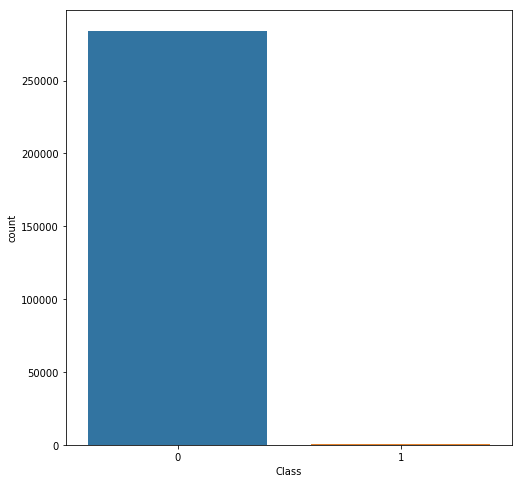

In [8]:
plt.figure(figsize=(8, 8))
sns.countplot('Class', data=credit_df)

### 3- Checking Missing Data

If there are any missing data in our dataset, we need to deal with them before training. Data Imputation is a critical step in the Feature Engineering phase.

In [9]:
credit_df.isna().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

### 3- Feature Correlation

A correlation matrix is a way to show the correlation between different variables in a dataset. Each cell in the table shows the correlation between two variables. A correlation matrix is used to summarize data and find what , as an input into a more advanced analysis

**Positive Correlation means:** As feature X increases, feature Y increases and vice versa.

**Negative Correlation means:** As feature X go in one direction (Increase), feature Y goes in the other direction (Decrease)

Let's plot the first correlation matrix for the imbalanced data.

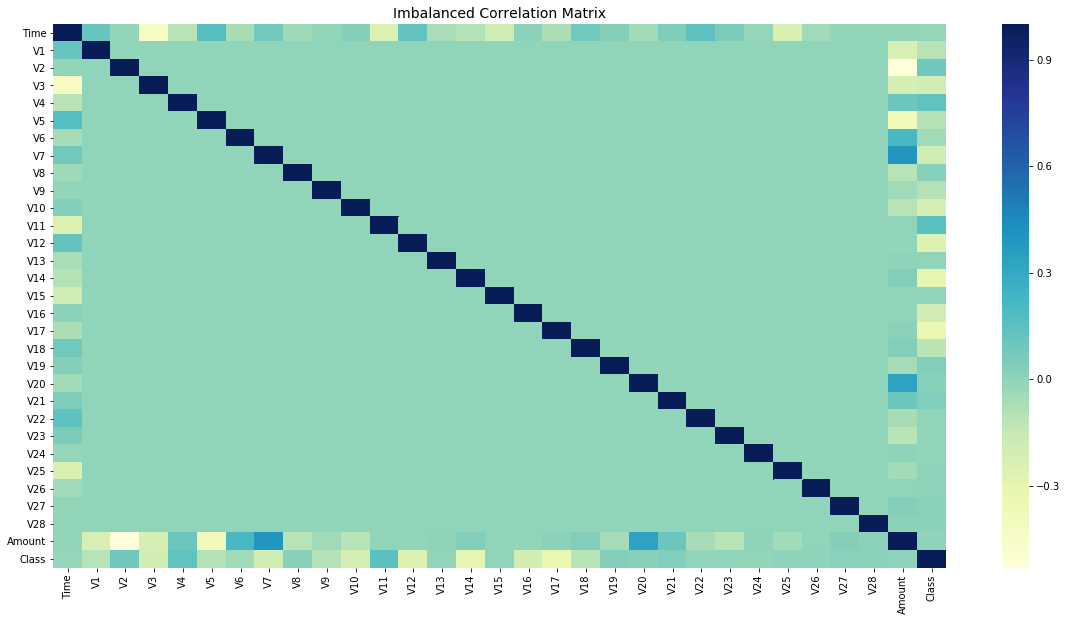

In [10]:
# Sample figsize in inches
fig, ax = plt.subplots(figsize=(20,10))         

# Imbalanced DataFrame Correlation
corr = credit_df.corr()
sns.heatmap(corr, cmap='YlGnBu', annot_kws={'size':30}, ax=ax)
ax.set_title("Imbalanced Correlation Matrix", fontsize=14)

plt.show()

# Feature Engineering

1- Scale the features that needs scaling.

2- Fix the target feature imbalance problem.

3- Detect and Remove Outliers.

3- Split the data to train, validation and test.

<img src="./fengineering.png" width="200" height="200">

### 1- Fixing The Feature Scaling Problem For (Time and Amount)

In [11]:
# Since most of our data has already been scaled we should scale the columns that are left to scale (Amount and Time)
from sklearn.preprocessing import RobustScaler

# RobustScaler is robust to outliers.

credit_df['amount_after_scaling'] = RobustScaler().fit_transform(credit_df['Amount'].values.reshape(-1,1))
credit_df['time_after_scaling'] = RobustScaler().fit_transform(credit_df['Time'].values.reshape(-1,1))

credit_df.drop(['Time','Amount'], axis=1, inplace=True)

# Place the class in the begining of the dataframe
Class = credit_df['Class']
credit_df.drop(['Class'], axis=1, inplace=True)
credit_df.insert(0, 'Class', Class)

In [12]:
credit_df.describe()

,Class,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,amount_after_scaling,time_after_scaling
count,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000
mean,0.001727,0.000000,0.000000,-0.000000,0.000000,-0.000000,0.000000,-0.000000,-0.000000,-0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,-0.000000,0.927124,0.118914
std,0.041527,1.958696,1.651309,1.516255,1.415869,1.380247,1.332271,1.237094,1.194353,1.098632,1.088850,1.020713,0.999201,0.995274,0.958596,0.915316,0.876253,0.849337,0.838176,0.814041,0.770925,0.734524,0.725702,0.624460,0.605647,0.521278,0.482227,0.403632,0.330083,3.495006,0.557903
min,0.000000,-56.407510,-72.715728,-48.325589,-5.683171,-113.743307,-26.160506,-43.557242,-73.216718,-13.434066,-24.588262,-4.797473,-18.683715,-5.791881,-19.214325,-4.498945,-14.129855,-25.162799,-9.498746,-7.213527,-54.497720,-34.830382,-10.933144,-44.807735,-2.836627,-10.295397,-2.604551,-22.565679,-15.430084,-0.307413,-0.994983
25%,0.000000,-0.920373,-0.598550,-0.890365,-0.848640,-0.691597,-0.768296,-0.554076,-0.208630,-0.643098,-0.535426,-0.762494,-0.405571,-0.648539,-0.425574,-0.582884,-0.468037,-0.483748,-0.498850,-0.456299,-0.211721,-0.228395,-0.542350,-0.161846,-0.354586,-0.317145,-0.326984,-0.070840,-0.052960,-0.229162,-0.358210
50%,0.000000,0.018109,0.065486,0.179846,-0.019847,-0.054336,-0.274187,0.040103,0.022358,-0.051429,-0.092917,-0.032757,0.140033,-0.013568,0.050601,0.048072,0.066413,-0.065676,-0.003636,0.003735,-0.062481,-0.029450,0.006782,-0.011193,0.040976,0.016594,-0.052139,0.001342,0.011244,0.000000,0.000000
75%,0.000000,1.315642,0.803724,1.027196,0.743341,0.611926,0.398565,0.570436,0.327346,0.597139,0.453923,0.739593,0.618238,0.662505,0.493150,0.648821,0.523296,0.399675,0.500807,0.458949,0.133041,0.186377,0.528554,0.147642,0.439527,0.350716,0.240952,0.091045,0.078280,0.770838,0.641790
max,1.000000,2.454930,22.057729,9.382558,16.875344,34.801666,73.301626,120.589494,20.007208,15.594995,23.745136,12.018913,7.848392,7.126883,10.526766,8.877742,17.315112,9.253526,5.041069,5.591971,39.420904,27.202839,10.503090,22.528412,4.584549,7.519589,3.517346,31.612198,33.847808,358.683155,1.035022


We can see immediately that:
- `time_after_scaling` appears to be quite evenly distributed and scaled with min and max values are within the range of the other features
- `amount_after_scaling` transaction amount values are also scaled to be within the range of the other features with min of -0.307 and max of 358.68

### 2- Fix the target feature imbalance problem (Resampling)

<img src="./resampling.png">

#### Undersampling The Class Feature

In [13]:
# Shuffle the Dataset.
shuffled_df = credit_df.sample(frac=1,random_state=4)

# amount of fraud classes 492 rows.
fraud_df = shuffled_df.loc[shuffled_df['Class'] == 1]

#Randomly select 492 observations.
non_fraud_df = shuffled_df.loc[shuffled_df['Class'] == 0].sample(n=492,random_state=42)
normalized_df = pd.concat([fraud_df, non_fraud_df])

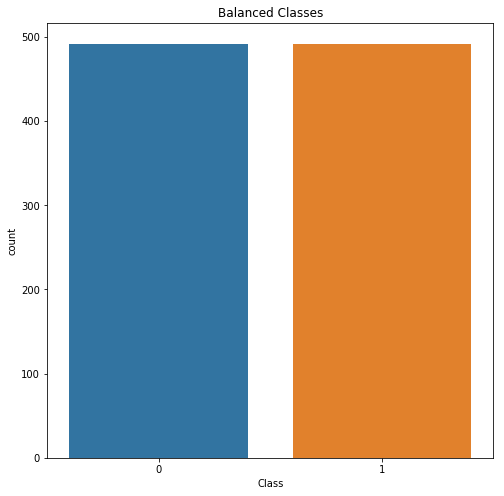

In [14]:
plt.figure(figsize=(8, 8))
sns.countplot('Class', data=normalized_df)
plt.title('Balanced Classes')
plt.show()

#### Oversampling The Class Feature

In [16]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(sampling_strategy='minority', random_state=7)

oversampled_trainX, oversampled_trainY = sm.fit_sample(credit_df.drop('Class', axis=1), credit_df['Class'])
oversampled_train = pd.concat([pd.DataFrame(oversampled_trainY), pd.DataFrame(oversampled_trainX)], axis=1)
oversampled_train.columns = normalized_df.columns

In [17]:
normalized_df.head()

,Class,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,amount_after_scaling,time_after_scaling
9179,1,-2.880042,5.225442,-11.063330,6.689951,-5.759924,-2.244031,-11.199975,4.014722,-3.429304,-11.561950,10.446847,-15.479052,0.734442,-13.883779,0.821440,-11.911483,-18.103004,-6.837835,3.126929,1.191444,2.002883,0.351102,0.795255,-0.778379,-1.646815,0.487539,1.427713,0.583172,-0.293440,-0.840776
223618,1,-2.006582,3.676577,-5.463811,7.232058,-1.627859,-0.996755,-4.299833,2.268867,-3.651067,-4.400930,4.213213,-5.737815,-0.875693,-8.893726,-0.562434,-3.281784,-4.368986,-0.736734,1.609293,0.474414,0.713907,-0.063868,0.167947,-0.449864,0.023702,0.536905,0.485864,-0.042393,-0.293440,0.690375
9487,1,-4.153014,8.204797,-15.031714,10.330100,-3.994426,-3.250013,-10.415698,4.620804,-5.711248,-11.797181,11.277921,-16.728339,0.241368,-17.721638,-0.387300,-10.322017,-13.959085,-5.030710,1.197266,1.412625,1.976988,0.256510,0.485908,-1.198821,-0.526567,0.634874,1.627209,0.723235,-0.293440,-0.829650
10497,1,1.189784,0.942289,0.082334,3.024050,0.412406,-0.214415,0.053558,-0.110353,0.883798,-0.554224,0.154921,-2.776757,1.641207,-0.456077,-1.240414,0.857323,1.707024,0.526349,-0.865105,-0.143435,-0.502636,-1.047398,-0.056752,-0.340688,0.541235,-0.098300,-0.003041,0.049819,-0.254454,-0.792678
250761,1,-0.512349,4.827060,-7.973939,7.334059,0.367704,-2.055129,-2.935856,1.431008,-4.544722,-5.258096,5.716319,-5.810407,0.723293,-12.289133,0.378773,-2.020734,-2.039703,0.658183,0.832574,0.804101,0.535620,-0.459496,-0.009364,-1.140436,-0.006445,0.527970,0.558881,0.126517,-0.296653,0.826631


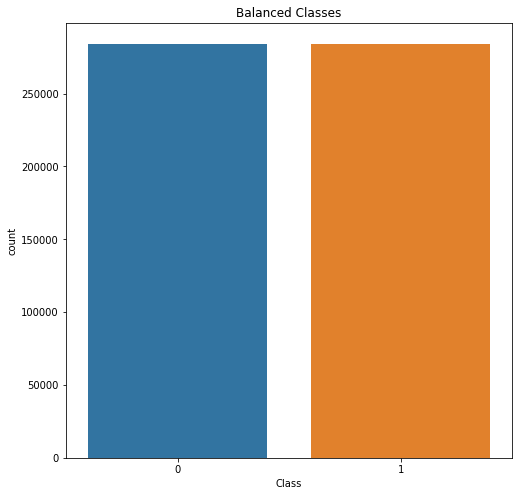

In [18]:
plt.figure(figsize=(8, 8))
sns.countplot('Class', data=oversampled_train)
plt.title('Balanced Classes')
plt.show()

### Check The Correlation Matrix After Downsampling

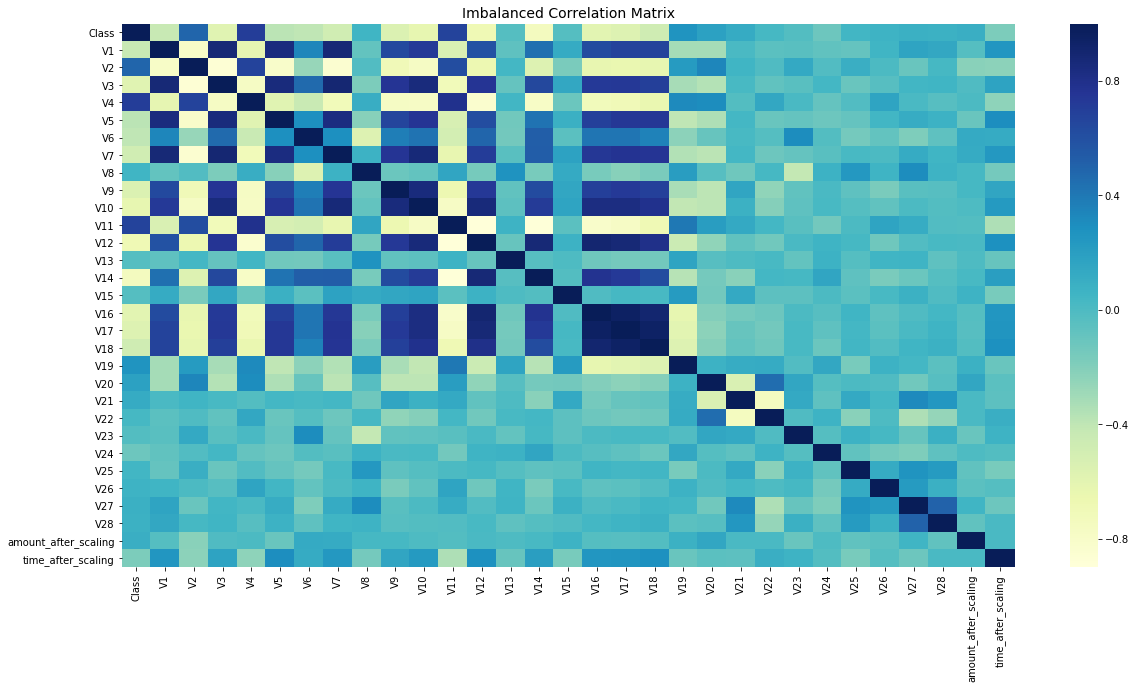

In [19]:
fig, ax = plt.subplots(figsize=(20,10))         

# Imbalanced DataFrame Correlation
corr = normalized_df.corr()
sns.heatmap(corr, cmap='YlGnBu', annot_kws={'size':30}, ax=ax)
ax.set_title("Imbalanced Correlation Matrix", fontsize=14)

plt.show()

**Negative Correlations:** Some features, such as V17, V14, V12 are negatively correlated with the target class. That means that the lower these values, the more likely the transaction will be a fraudulent.

**Positive Correlations:** Features V2, V4, V11 are positively correlated. That means that the higher these values, the more likely the transaction will be a fraudulent.

Now, let's find any outliers in those features:

--------------------



### Boxplot (Detecting Outliers)

<img src="./plotbox.png">

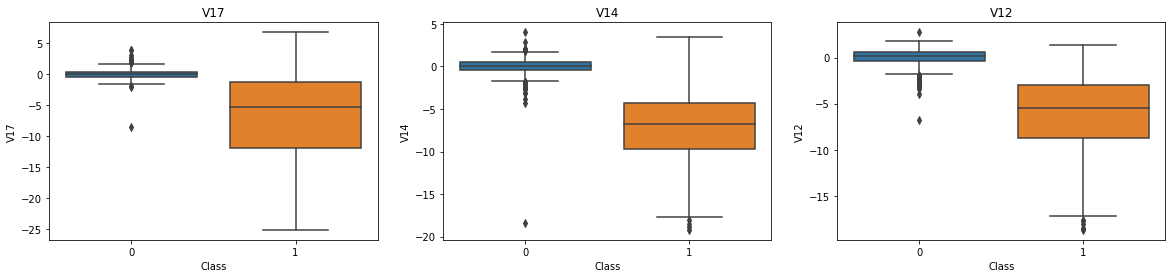

In [20]:
fig, axes = plt.subplots(ncols=3, figsize=(20,4))

# Negative Correlations with our Class (The lower our feature value the more likely it will be a fraud transaction)
sns.boxplot(x="Class", y="V17", data=normalized_df, ax=axes[0])
axes[0].set_title('V17')

sns.boxplot(x="Class", y="V14", data=normalized_df, ax=axes[1])
axes[1].set_title('V14')


sns.boxplot(x="Class", y="V12", data=normalized_df, ax=axes[2])
axes[2].set_title('V12')


plt.show()

### 3- Remove Outliers and re-plot the Boxplot

In [21]:
V17_non_fraud = normalized_df.query('V17 > -7 & Class == 0')
V17_fraud = normalized_df.query('Class == 1')
normalized_df_no_outlier = pd.concat([V17_non_fraud,V17_fraud])



#### Check the Boxplot after removing the major outliers.

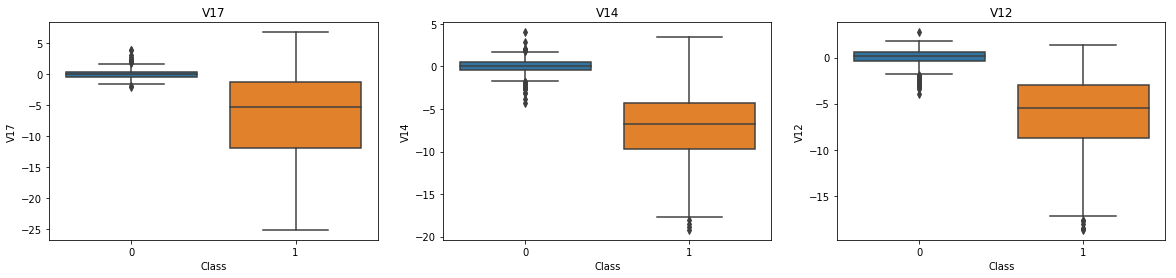

In [22]:
fig, axes = plt.subplots(ncols=3, figsize=(20,4))

# Negative Correlations with our Class (The lower our feature value the more likely it will be a fraud transaction)
sns.boxplot(x="Class", y="V17", data=normalized_df_no_outlier, ax=axes[0])
axes[0].set_title('V17')

sns.boxplot(x="Class", y="V14", data=normalized_df_no_outlier, ax=axes[1])
axes[1].set_title('V14')


sns.boxplot(x="Class", y="V12", data=normalized_df_no_outlier, ax=axes[2])
axes[2].set_title('V12')


plt.show()

#### Shuffle the normalized dataset before splitting

In [23]:
shuffled_normalized_df = normalized_df.sample(frac=1)
shuffled_normalized_df.head()

,Class,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,amount_after_scaling,time_after_scaling
122479,1,-5.622469,3.480623,-6.200677,4.311234,-5.226286,-1.341764,-5.220941,2.682844,-2.921484,-6.561257,3.211264,-6.861661,0.326462,-7.755254,0.504652,-6.276617,-10.611715,-4.146774,2.197288,-0.156289,0.949569,-0.428986,-0.350676,0.197550,0.159234,-0.377791,-0.213562,0.459529,2.763921,-0.095361
142146,0,1.227688,-0.538043,0.694117,-0.841786,-1.009983,-0.192264,-0.781185,0.231505,2.117121,-1.070126,-0.848278,-0.257556,-1.812772,0.219183,1.749502,-0.544958,0.106497,0.078768,0.345406,-0.262135,-0.029228,0.113835,-0.028820,-0.311916,0.413950,-0.628496,0.097796,0.024339,-0.293440,-0.001198
141258,1,-0.937843,3.462889,-6.445104,4.932199,-2.233983,-2.291561,-5.695594,1.338825,-4.322377,-8.099119,7.182967,-9.445943,-0.314620,-12.991466,-0.136359,-6.367524,-12.734394,-3.845130,1.007667,1.129532,1.066550,-0.521657,-0.319917,-0.405859,0.906802,1.165784,1.374495,0.729889,-0.307413,-0.005733
125391,0,-1.147673,1.138088,1.763604,2.668284,-0.193433,0.443161,-0.176167,0.492359,-1.081954,1.272832,0.561879,-0.520456,-0.977947,0.495304,0.976882,0.557813,-0.391239,1.224517,1.004573,0.129306,0.215507,0.687838,-0.009178,-0.014145,-0.201929,0.288313,-0.182381,-0.049490,-0.158597,-0.082684
128299,0,1.384366,-0.773432,-0.923090,-0.962244,1.363332,3.726718,-1.154460,0.896437,-0.537272,0.651825,-0.795046,-0.025619,0.122499,-0.204765,-0.335693,-1.511402,-0.160776,1.229267,-0.201200,-0.404155,-0.523628,-0.954522,-0.023644,1.015295,0.596320,0.428017,0.013773,0.010433,-0.178858,-0.070807


### 4- Split the train/test data (Used For Evaluation Step)

In [24]:
train_data, validation_data, test_data = np.split(shuffled_normalized_df, [int(0.7 * len(shuffled_normalized_df)), int(0.9 * len(shuffled_normalized_df))])
train_data.to_csv('train.csv', header=False, index=False)
validation_data.to_csv('validation.csv', header=False, index=False)

Now we'll upload these files to S3.

In [25]:
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'train/train.csv')).upload_file('train.csv')
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'validation/validation.csv')).upload_file('validation.csv')

---
## Train

Moving onto training, first we'll need to specify the locations of the XGBoost algorithm containers.

In [27]:
from sagemaker.amazon.amazon_estimator import get_image_uri
container = get_image_uri(boto3.Session().region_name, 'xgboost', '0.90-1')
container

'246618743249.dkr.ecr.us-west-2.amazonaws.com/sagemaker-xgboost:0.90-1-cpu-py3'

Then, because we're training with the CSV file format, we'll create `s3_input`s that our training function can use as a pointer to the files in S3.

In [29]:
s3_input_train = sagemaker.s3_input(s3_data='s3://{}/{}/train'.format(bucket, prefix), content_type='csv')
s3_input_validation = sagemaker.s3_input(s3_data='s3://{}/{}/validation/'.format(bucket, prefix), content_type='csv')

Now, we can specify a few parameters like what type of training instances we'd like to use and how many, as well as our XGBoost hyperparameters.  A few key hyperparameters are:
- `max_depth` controls how deep each tree within the algorithm can be built.  Deeper trees can lead to better fit, but are more computationally expensive and can lead to overfitting.  There is typically some trade-off in model performance that needs to be explored between a large number of shallow trees and a smaller number of deeper trees.
- `subsample` controls sampling of the training data.  This technique can help reduce overfitting, but setting it too low can also starve the model of data.
- `num_round` controls the number of boosting rounds.  This is essentially the subsequent models that are trained using the residuals of previous iterations.  Again, more rounds should produce a better fit on the training data, but can be computationally expensive or lead to overfitting.
- `eta` controls how aggressive each round of boosting is.  Larger values lead to more conservative boosting.
- `gamma` controls how aggressively trees are grown.  Larger values lead to more conservative models.

Binary classification error rate. It is calculated as #(wrong cases)/#(all cases)


More detail on XGBoost's hyperparmeters can be found on their GitHub [page](https://github.com/dmlc/xgboost/blob/master/doc/parameter.md).

In [30]:
sess = sagemaker.Session()

xgb = sagemaker.estimator.Estimator(container,
                                    role, 
                                    train_instance_count=1, 
                                    train_instance_type='ml.m4.xlarge',
                                    output_path='s3://{}/{}/output'.format(bucket, prefix),
                                    sagemaker_session=sess)
xgb.set_hyperparameters(
                        max_depth=10,
                        objective='binary:logistic',
                        num_round=100)

xgb.fit({'train': s3_input_train, 'validation': s3_input_validation}, wait=False) 

In [32]:
job_name = xgb.latest_training_job.job_name
job_name

'sagemaker-xgboost-2020-03-09-17-00-32-081'

In [35]:
import time
sm = boto3.client('sagemaker')

job_run_status = ''
while job_run_status not in ('Failed', 'Completed', 'Stopped'):
    job_run_status = sm.describe_training_job(TrainingJobName=job_name)['TrainingJobStatus']
    print("job status:{}".format(job_run_status))
    time.sleep(30)

job status:Completed


---
## SageMaker Deployment

Now that we've trained the algorithm, let's create a model and deploy it to a hosted endpoint.
<img src="./deployment.png" width="200" height="200">


In [36]:
xgb_predictor = xgb.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge', wait=False)

In [37]:
endpiont_name = xgb_predictor.endpoint
endpiont_name

'sagemaker-xgboost-2020-03-09-17-00-32-081'

In [42]:
run_status = sm.describe_endpoint(EndpointName=endpiont_name)['EndpointStatus']

while run_status not in ('InService'):
    run_status = sm.describe_endpoint(EndpointName=endpiont_name)['EndpointStatus']
    print("endpoint status:{}".format(run_status))
    if run_status != 'InService':
        time.sleep(30)

# sm.describe_endpoint(EndpointName=endpiont_name)['EndpointStatus']

endpoint status:Creating
endpoint status:Creating
endpoint status:InService


### Evaluate

Now that we have a hosted endpoint running, we can make real-time predictions from our model very easily, simply by making an http POST request.  But first, we'll need to setup serializers and deserializers for passing our `test_data` NumPy arrays to the model behind the endpoint.

In [43]:
xgb_predictor.content_type = 'text/csv'
xgb_predictor.serializer = csv_serializer
xgb_predictor.deserializer = None

Now, we'll use a simple function to:
1. Loop over our test dataset
1. Split it into mini-batches of rows 
1. Convert those mini-batchs to CSV string payloads
1. Retrieve mini-batch predictions by invoking the XGBoost endpoint
1. Collect predictions and convert from the CSV output our model provides into a NumPy array

In [44]:
def predict(data, rows=500):
    split_array = np.array_split(data, int(data.shape[0] / float(rows) + 1))
    predictions = ''
    for array in split_array:
        predictions = ','.join([predictions, xgb_predictor.predict(array).decode('utf-8')])

    return np.fromstring(predictions[1:], sep=',')

predictions = predict(test_data.as_matrix()[:, 1:])

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:9: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


There are many ways to compare the performance of a machine learning model, but let's start by simply by comparing actual to predicted values.  In this case, we're simply predicting whether the credit card transaction is Fraud (`1`) or not (`0`), which produces a simple confusion matrix.

#### Print Confusion Matrix
<img src="./Confusion_matrix.png" width="200" height="200">


In [45]:
pd.crosstab(index=test_data.iloc[:, 0], columns=np.round(predictions), rownames=['actual'], colnames=['predictions'])

predictions,0.0,1.0
actual,,
0,45,1
1,4,49


## Model Tuning:


<img src="./model_tuning.png" width="700" height="700">



### Tuning The Model - Hyperparameter Optimization (HPO)

![HPO](./gif.gif "HPO Experiment")

![HPO](./Optimized_Controller.gif "HPO Experiment")


**Source: ** http://arxiv.org/abs/1509.01066 and https://www.youtube.com/watch?v=GiqNQdzc5TI


Hyperparameter tuning is a supervised machine learning regression problem. Given a set of input features (the hyperparameters), hyperparameter tuning optimizes a model for the metric that you choose. hyperparameter tuning makes guesses about which hyperparameter combinations are likely to get the best results, and runs training jobs to test these guesses.

In [46]:
hyperparameter_ranges = {'eta': ContinuousParameter(0, 1),
                        'min_child_weight': ContinuousParameter(1, 10),
                        'alpha': ContinuousParameter(0, 2),
                        'max_depth': IntegerParameter(1, 10)}
objective_metric_name = 'validation:error'

tuner = HyperparameterTuner(xgb,
                            objective_metric_name,
                            hyperparameter_ranges,
                            max_jobs=20,
                            objective_type='Minimize',
                            max_parallel_jobs=3)

In [47]:
tuner.fit({'train': s3_input_train, 'validation': s3_input_validation}, include_cls_metadata=False)

In [48]:
tuner_job_name = tuner.latest_tuning_job.job_name
tuner_job_name

'sagemaker-xgboost-200309-1717'

Check the Hyperparameter Tuning Job Status

In [49]:
boto3.client('sagemaker').describe_hyper_parameter_tuning_job(
    HyperParameterTuningJobName=tuner_job_name)['HyperParameterTuningJobStatus']

'InProgress'

### Making an inference request After Loading The Model

Get the model artifact from S3 Location then the unpack it and load it to use it for prediction.

In [57]:
# Download the model artifacts before running the next piece of code
respone = sm.describe_training_job(TrainingJobName=job_name)
model_url = respone['ModelArtifacts']['S3ModelArtifacts']
model_url

's3://beyoung-fraud-detection-20200309/xgboost-balanced-data/output/sagemaker-xgboost-2020-03-09-17-00-32-081/output/model.tar.gz'

In [58]:
!aws s3 cp {model_url} ./model.tar.gz

download: s3://beyoung-fraud-detection-20200309/xgboost-balanced-data/output/sagemaker-xgboost-2020-03-09-17-00-32-081/output/model.tar.gz to ./model.tar.gz


In [60]:
!tar -xvf ./model.tar.gz

xgboost-model


In [ ]:
# import pickle
# import xgboost as xgb
# transaction= "-1.009630,0.141192,0.167167,-0.808785,2.112167,-1.294934,0.592454,-0.049872,-0.284882,-1.296757,-1.010293,-0.272631,-0.139809,-0.918097,-0.475136,0.519497,0.158822,-0.120745,-0.519128,0.108956,-0.225473,-0.947079,0.054725,0.368866,-0.158482,0.070904,0.022035,0.177674,-0.279746,0.391123"
# test = transaction.split(',')
# data = np.asarray(test).reshape((1,-1))
# test_matrix = xgb.DMatrix(data)
# filename = "./xgboost-model"
# xgb_loaded = pickle.load(open(filename, 'rb'))
# predictions = xgb_loaded.predict(test_matrix)
# predictions[0]

## Interperting the Machine Learning Model

In [ ]:
# from xgboost import plot_tree, Booster
# import xgboost as xgb
# import matplotlib.pyplot as plt
# import pickle as pkl
# from xgboost import plot_tree, plot_importance
# from matplotlib.pylab import rcParams

# filename='./xgboost-model'
# # plot single tree
# rcParams['figure.figsize'] = 50,50
 
# model = pkl.load(open(filename,'rb')) 
# plot_tree(model, num_trees=4)
# plt.show()


## Now, Let's Deploy The Model in Lambda and API Gateway

Using Cloud9 which is a cloud-based integrated development environment (IDE) that lets you write, run, and debug your code with just a browser. It includes a code editor, debugger, and terminal. Cloud9 comes prepackaged with essential tools for popular programming languages, including JavaScript, Python, PHP, and more, so you don’t need to install files or configure your development machine to start new projects.


## Useful Resources:

- Amazon Sagemaker: https://docs.aws.amazon.com/sagemaker/latest/dg/whatis.html
- XGBoost Algorithm: https://xgboost.readthedocs.io/en/latest/
- Oversampling vs Undersampling: https://en.wikipedia.org/wiki/Oversampling_and_undersampling_in_data_analysis
- Why Correlation Matters: https://towardsdatascience.com/why-feature-correlation-matters-a-lot-847e8ba439c4
- Correlation Matrix: https://en.wikipedia.org/wiki/Correlation_and_dependence#Correlation_matrices
- Hyperparameters Optimization: https://aws.amazon.com/blogs/aws/sagemaker-automatic-model-tuning/
